Dataset Description

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

print('numpy version : ',np.__version__)
print('pandas version : ',pd.__version__)
print('seaborn version : ',sns.__version__)

from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA 
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from scipy.cluster.hierarchy import linkage,dendrogram

numpy version :  1.20.3
pandas version :  1.3.4
seaborn version :  0.11.2


In [2]:
sns.set(rc={'figure.figsize':(20.7,8.27)})
sns.set_style("whitegrid")
sns.color_palette("dark")
plt.style.use("fivethirtyeight")

In [3]:
data = pd.read_csv('flight.csv')
df = data.copy()
df.head()

,MEMBER_NO,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,FFP_TIER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,AGE,LOAD_TIME,...,SUM_YR_2,SEG_KM_SUM,LAST_FLIGHT_DATE,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight
0,54993,11/2/2006,12/24/2008,Male,6,.,beijing,CN,31.0,3/31/2014,...,234188.0,580717,3/31/2014,1,3.483254,18,34,0.961639,619760,50
1,28065,2/19/2007,8/3/2007,Male,6,NaN,beijing,CN,42.0,3/31/2014,...,167434.0,293678,3/25/2014,7,5.194245,17,29,1.252314,415768,33
2,55106,2/1/2007,8/30/2007,Male,6,.,beijing,CN,40.0,3/31/2014,...,164982.0,283712,3/21/2014,11,5.298507,18,20,1.254676,406361,26
3,21189,8/22/2008,8/23/2008,Male,5,Los Angeles,CA,US,64.0,3/31/2014,...,125500.0,281336,12/26/2013,97,27.863636,73,11,1.090870,372204,12
4,39546,4/10/2009,4/15/2009,Male,6,guiyang,guizhou,CN,48.0,3/31/2014,...,130702.0,309928,3/27/2014,5,4.788079,47,27,0.970658,338813,39


## **EDA** ##

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62988 entries, 0 to 62987
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MEMBER_NO          62988 non-null  int64  
 1   FFP_DATE           62988 non-null  object 
 2   FIRST_FLIGHT_DATE  62988 non-null  object 
 3   GENDER             62985 non-null  object 
 4   FFP_TIER           62988 non-null  int64  
 5   WORK_CITY          60719 non-null  object 
 6   WORK_PROVINCE      59740 non-null  object 
 7   WORK_COUNTRY       62962 non-null  object 
 8   AGE                62568 non-null  float64
 9   LOAD_TIME          62988 non-null  object 
 10  FLIGHT_COUNT       62988 non-null  int64  
 11  BP_SUM             62988 non-null  int64  
 12  SUM_YR_1           62437 non-null  float64
 13  SUM_YR_2           62850 non-null  float64
 14  SEG_KM_SUM         62988 non-null  int64  
 15  LAST_FLIGHT_DATE   62988 non-null  object 
 16  LAST_TO_END        629

Intrepetasi dataset :

*   Terdapat 23 kolom
*   Memiliki range index 62.988 baris
*   Terdapat missing values pada fitur GENDER, WORK_CITY, WORK_PROVINCE, WORK_COUNTRY, AGE, SUM_YR_1, SUM_YR_2
*   Tipe data pada fitur FFP_DATE, FIRST_FLIGHT_DATE, LOAD_TIME, LAST_FLIGHT_DATE sebaiknya diubah menjadi datetime/timestamp karena menunjukkan waktu
*   Tipe data pada fitur AGE sebaiknya diubah menjadi integer

In [5]:
# pengelompokan kolom berdasarkan jenisnya
nums = ['MEMBER_NO', 'FFP_TIER', 'AGE', 'FLIGHT_COUNT', 'BP_SUM', 'SUM_YR_1', 'SUM_YR_2', 'SEG_KM_SUM','LAST_TO_END','AVG_INTERVAL','MAX_INTERVAL','EXCHANGE_COUNT','avg_discount','Points_Sum','Point_NotFlight']
cats = ['FFP_DATE', 'FIRST_FLIGHT_DATE', 'GENDER', 'WORK_CITY', 'WORK_PROVINCE','WORK_COUNTRY','LOAD_TIME','LAST_FLIGHT_DATE']

In [6]:
# ringkasan statistik dari kolom numerik
df[nums].describe()

,MEMBER_NO,FFP_TIER,AGE,FLIGHT_COUNT,BP_SUM,SUM_YR_1,SUM_YR_2,SEG_KM_SUM,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight
count,62988.000000,62988.000000,62568.000000,62988.000000,62988.000000,62437.000000,62850.000000,62988.000000,62988.000000,62988.000000,62988.000000,62988.000000,62988.000000,62988.0000,62988.000000
mean,31494.500000,4.102162,42.476346,11.839414,10925.081254,5355.376064,5604.026014,17123.878691,176.120102,67.749788,166.033895,0.319775,0.721558,12545.7771,2.728155
std,18183.213715,0.373856,9.885915,14.049471,16339.486151,8109.450147,8703.364247,20960.844623,183.822223,77.517866,123.397180,1.136004,0.185427,20507.8167,7.364164
min,1.000000,4.000000,6.000000,2.000000,0.000000,0.000000,0.000000,368.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
25%,15747.750000,4.000000,35.000000,3.000000,2518.000000,1003.000000,780.000000,4747.000000,29.000000,23.370370,79.000000,0.000000,0.611997,2775.0000,0.000000
50%,31494.500000,4.000000,41.000000,7.000000,5700.000000,2800.000000,2773.000000,9994.000000,108.000000,44.666667,143.000000,0.000000,0.711856,6328.5000,0.000000
75%,47241.250000,4.000000,48.000000,15.000000,12831.000000,6574.000000,6845.750000,21271.250000,268.000000,82.000000,228.000000,0.000000,0.809476,14302.5000,1.000000
max,62988.000000,6.000000,110.000000,213.000000,505308.000000,239560.000000,234188.000000,580717.000000,731.000000,728.000000,728.000000,46.000000,1.500000,985572.0000,140.000000


Interpretasi data pada kolom nums :


*   Kolom - kolom sekilas ada beberapa fitur yangg asimetrik distribusinya (mean dan median berbeda signifikan)
*   Kolom FLIGHT_COUNT, BP_SUM, SUM_YR_1 ,SEG_KM_SUM, LAST_TO_END, AVG_INTERVAL, MAX_INTERVAL, Points_Sum, Point_NotFlight tampaknya skewed ke kanan
*   Kolom FFP_TIER merupakan kolom kategori
*   Kolom SUM_YR_1 dan SUM_YR_2 seharusnya integer karena merepresentasi jumlah/ sum
*   Kolom avg_discount, MEMBER_NO, dan FFP_TIER memiliki distribusi normal
Terdapat value 0 pada kolom SUM_YR_1 dan SUM_YR_2 yang tampak kurang tepat sehingga perlu dilakukan investigasi lebih lanjut
*   Terdapat customer dengan usia 110 tahun yang tampak tidak normal, lebih baik dihapus

In [7]:
# ringkasan categorical columns 
df[cats].describe()

,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,LOAD_TIME,LAST_FLIGHT_DATE
count,62988,62988,62985,60719,59740,62962,62988,62988
unique,3068,3406,2,3234,1165,118,1,731
top,1/13/2011,2/16/2013,Male,guangzhou,guangdong,CN,3/31/2014,3/31/2014
freq,184,96,48134,9386,17509,57748,62988,959


In [8]:
for col in cats:
    print(f'''Value count kolom {col}:''')
    print(df[col].value_counts())
    print()

Value count kolom FFP_DATE:
1/13/2011     184
1/1/2013      165
3/1/2013      100
11/17/2010     99
1/14/2011      95
             ... 
10/4/2005       1
5/18/2009       1
11/29/2004      1
11/7/2004       1
5/19/2009       1
Name: FFP_DATE, Length: 3068, dtype: int64

Value count kolom FIRST_FLIGHT_DATE:
2/16/2013    96
9/30/2012    85
2/15/2013    84
9/9/2005     78
4/21/2012    70
             ..
3/2/2005      1
4/12/2009     1
2/20/2005     1
1/27/2005     1
12/7/2004     1
Name: FIRST_FLIGHT_DATE, Length: 3406, dtype: int64

Value count kolom GENDER:
Male      48134
Female    14851
Name: GENDER, dtype: int64

Value count kolom WORK_CITY:
guangzhou    9386
beijing      7845
shanghai     5001
shenzhen     3605
dalian       1979
             ... 
KASUGAI         1
hainan          1
xinxishi        1
KA              1
lingshui        1
Name: WORK_CITY, Length: 3234, dtype: int64

Value count kolom WORK_PROVINCE:
guangdong        17509
beijing           8014
shanghai          4998
liao

Interpretasi data pada kolom cats:

*   Pada kolom GENDER menunjukan bahwa user didominasi Male
*   Pada kolom WORK_CITY didominasi penumpang dari Guangzhou
*   Pada kolom WORK_PROVINCE didominasi penumpang dari Guangdong
*   Pada kolom WORK_COUNTRY didominasi penumpang dari negara bagian CN
*   Pada kolom LOAD_TIME terlihat bahwa data diambil pada tanggal 3/31/2014, sehingga dapat digunakan sebagai cutoff date
*   Pada kolom LAST_FLIGHT_DATE didominasi datetime 3/31/2014
*   Pada kolom GENDER terdapat 2 nilai yaitu Male, Female
*   Pada kolom WORK_COUNTRY diduga terdapat singkatan nama negara CN, JP (japan), HK(Hongkong), SG (Singapore)

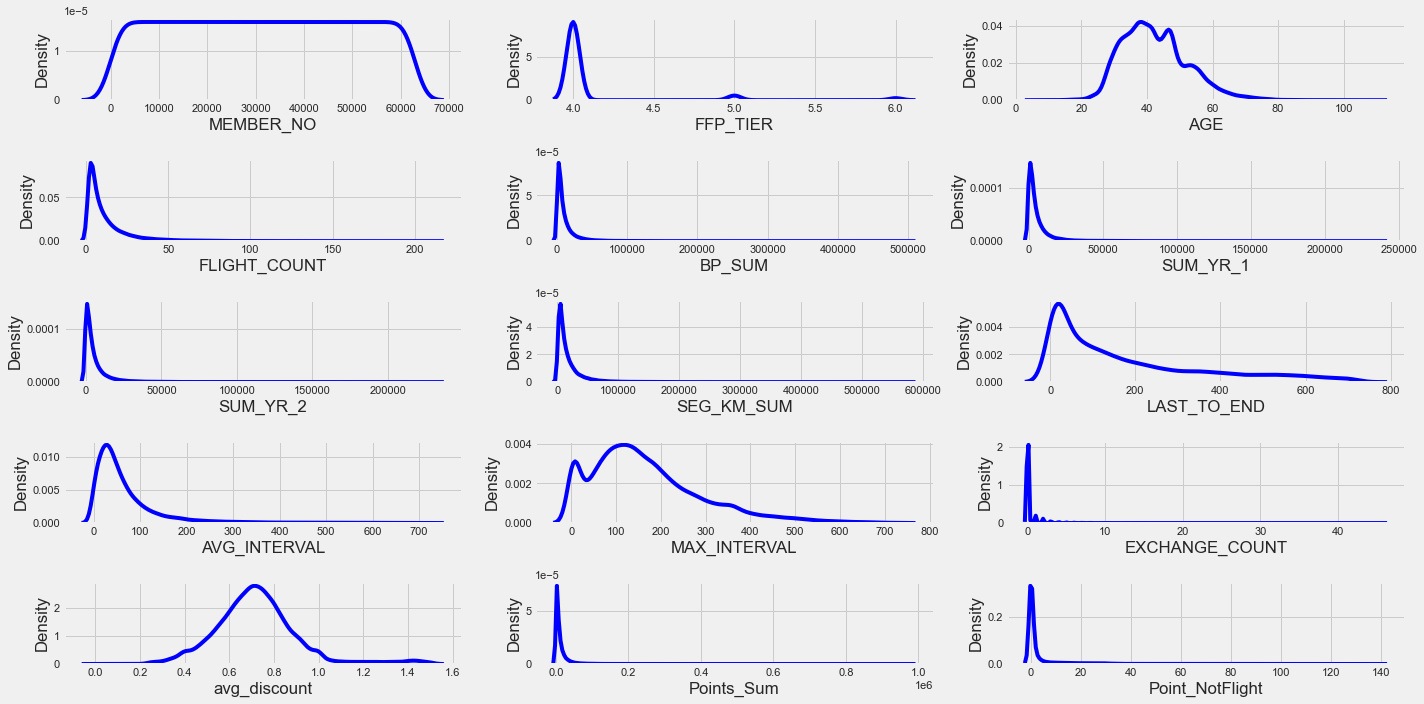

In [9]:
# Analisis univariat menggunakan histogram terhadap variabel numerik untuk melihat distribusi simetris atau skew
features = nums
plt.figure(figsize=(20, 10))
for i in range(0, len(nums)):
    plt.subplot(5, len(nums)/4, i+1)
    sns.kdeplot(x=df[features[i]], color='blue')
    plt.xlabel(features[i])
    plt.tight_layout()

In [10]:
# Analisis univariat menggunakan count plot terhadap variabel kategori
#plt.figure(figsize=(10, 30))
#for i in range(0, len(cats)):
    #plt.subplot(8, 1, i+1)
    #sns.countplot(df[cats[i]])
    #plt.tight_layout()

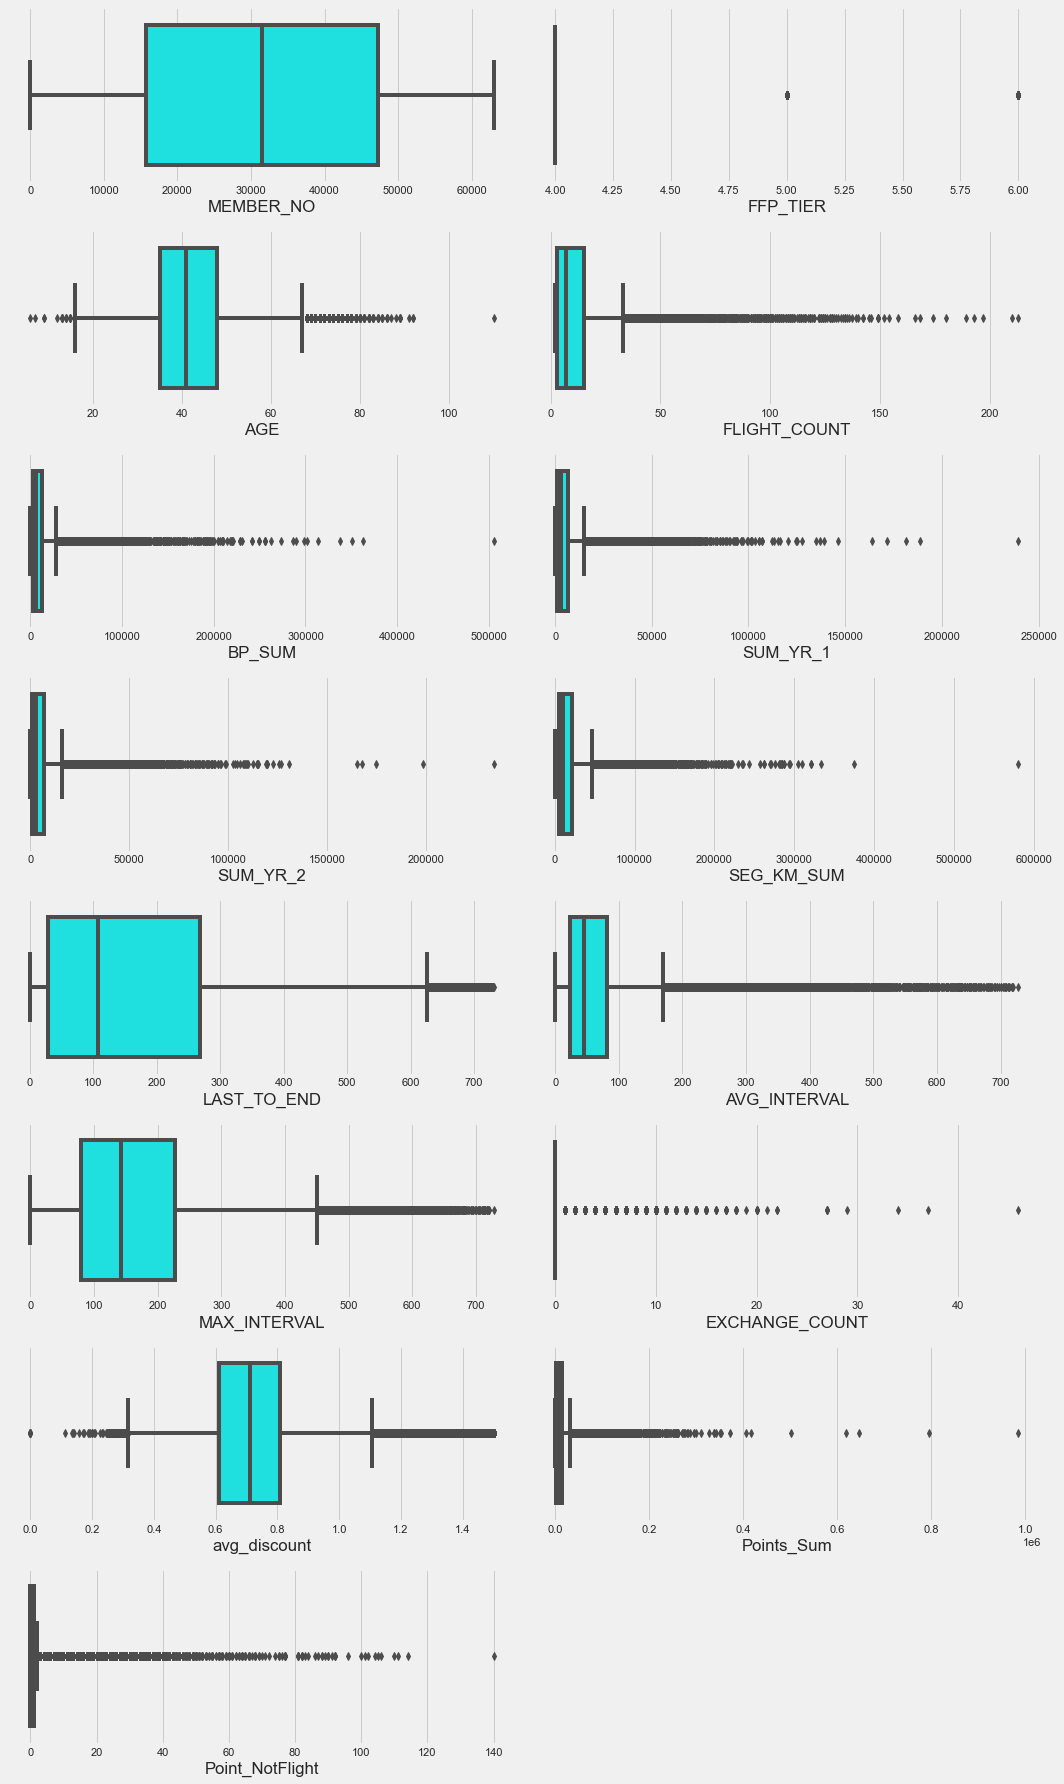

In [11]:
# Analisis univariat menggunakan boxplot terhadap variabel numerik untuk melihat adanya sebaran outlier
plt.figure(figsize=(15, 25))
for i in range(0, len(nums)):
    plt.subplot(8, 2, i+1)
    sns.boxplot(x=df[nums[i]], color='Cyan')
    plt.tight_layout()

plt.show()

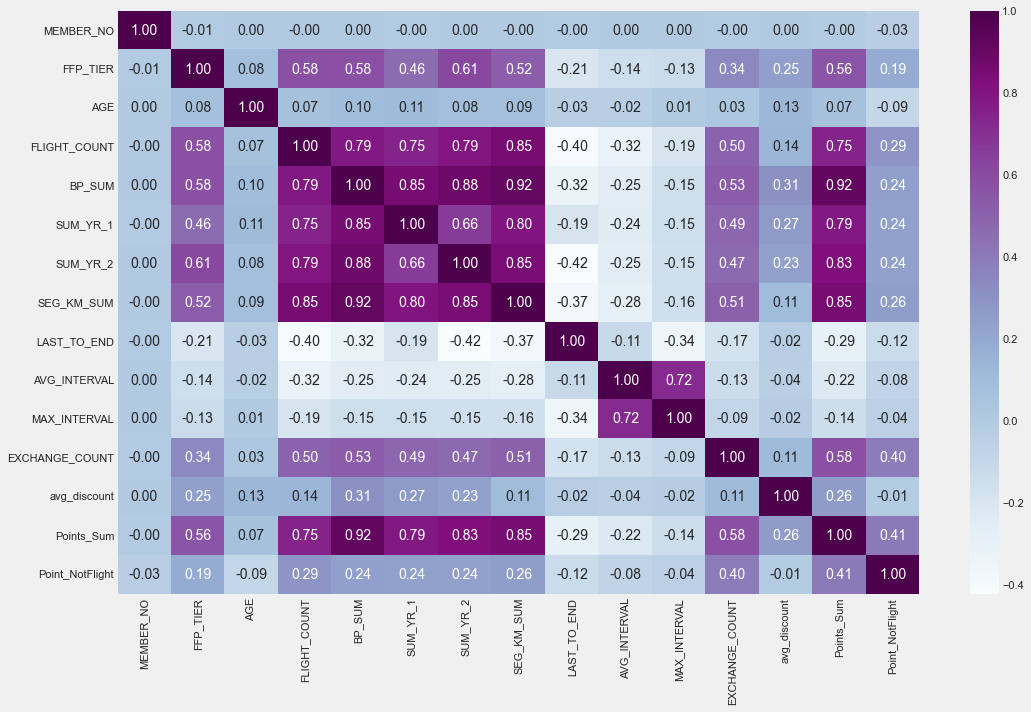

In [12]:
# Melihat korelasi antar fitur
corr_= df.corr()
plt.figure(figsize=(16,10))
sns.heatmap(corr_, annot=True, fmt = ".2f", cmap = "BuPu")

## **Data pre-processing** ##

In [13]:
# Melihat missing values
df.isna().sum()

MEMBER_NO               0
FFP_DATE                0
FIRST_FLIGHT_DATE       0
GENDER                  3
FFP_TIER                0
WORK_CITY            2269
WORK_PROVINCE        3248
WORK_COUNTRY           26
AGE                   420
LOAD_TIME               0
FLIGHT_COUNT            0
BP_SUM                  0
SUM_YR_1              551
SUM_YR_2              138
SEG_KM_SUM              0
LAST_FLIGHT_DATE        0
LAST_TO_END             0
AVG_INTERVAL            0
MAX_INTERVAL            0
EXCHANGE_COUNT          0
avg_discount            0
Points_Sum              0
Point_NotFlight         0
dtype: int64

In [14]:
# Menghapus missing value dibawah 5% (5%=3.149,4)
df = df.dropna(subset=['WORK_COUNTRY','AGE','SUM_YR_1','SUM_YR_2','WORK_CITY','GENDER'])
df.isna().sum()

MEMBER_NO               0
FFP_DATE                0
FIRST_FLIGHT_DATE       0
GENDER                  0
FFP_TIER                0
WORK_CITY               0
WORK_PROVINCE        1446
WORK_COUNTRY            0
AGE                     0
LOAD_TIME               0
FLIGHT_COUNT            0
BP_SUM                  0
SUM_YR_1                0
SUM_YR_2                0
SEG_KM_SUM              0
LAST_FLIGHT_DATE        0
LAST_TO_END             0
AVG_INTERVAL            0
MAX_INTERVAL            0
EXCHANGE_COUNT          0
avg_discount            0
Points_Sum              0
Point_NotFlight         0
dtype: int64

In [15]:
# Mengisi missing values pada kolom WORK_PROVINCE dengan modus
df['WORK_PROVINCE'].fillna(df['WORK_PROVINCE'].mode()[0], inplace=True)
df.isna().sum()

MEMBER_NO            0
FFP_DATE             0
FIRST_FLIGHT_DATE    0
GENDER               0
FFP_TIER             0
WORK_CITY            0
WORK_PROVINCE        0
WORK_COUNTRY         0
AGE                  0
LOAD_TIME            0
FLIGHT_COUNT         0
BP_SUM               0
SUM_YR_1             0
SUM_YR_2             0
SEG_KM_SUM           0
LAST_FLIGHT_DATE     0
LAST_TO_END          0
AVG_INTERVAL         0
MAX_INTERVAL         0
EXCHANGE_COUNT       0
avg_discount         0
Points_Sum           0
Point_NotFlight      0
dtype: int64

In [16]:
# Melihat data yang mengandung nilai anomali
df[df.LAST_FLIGHT_DATE.str.contains('2014/2/29')]

,MEMBER_NO,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,FFP_TIER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,AGE,LOAD_TIME,...,SUM_YR_2,SEG_KM_SUM,LAST_FLIGHT_DATE,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight
248,56497,6/17/2007,6/17/2007,Female,6,guangzhou,guangdong,CN,46.0,3/31/2014,...,70845.0,85000,2014/2/29 0:00:00,32,13.250000,57,0,1.373478,132653,4
447,17306,8/26/2009,4/29/2010,Male,5,haerbin,heilongjiang,CN,70.0,3/31/2014,...,46323.0,69453,2014/2/29 0:00:00,32,22.766667,75,6,1.375395,101413,7
473,915,11/10/2006,1/26/2007,Male,5,.,beijing,CN,39.0,3/31/2014,...,30580.0,65717,2014/2/29 0:00:00,32,14.250000,65,1,1.425974,93153,8
832,20336,7/13/2005,8/6/2005,Male,5,guangzhou,guangdong,CN,40.0,3/31/2014,...,36417.0,114222,2014/2/29 0:00:00,32,8.696203,34,2,0.664970,91476,15
1051,62884,5/24/2006,4/21/2007,Male,5,wuhan,hubei,CN,50.0,3/31/2014,...,35680.0,49859,2014/2/29 0:00:00,32,19.115385,72,4,1.388584,69047,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61539,55995,1/11/2013,7/10/2013,Male,4,dalianshi,liaoning,CN,23.0,3/31/2014,...,955.0,3513,2014/2/29 0:00:00,32,117.000000,211,0,0.276667,0,0
61871,48742,7/26/2009,7/26/2009,Male,4,tianjin,tianjin,CN,37.0,3/31/2014,...,966.0,1298,2014/2/29 0:00:00,32,135.000000,135,0,0.690000,1094,1
61909,9190,4/11/2011,4/20/2011,Male,4,guangzhou,guangdong,CN,34.0,3/31/2014,...,853.0,2595,2014/2/29 0:00:00,32,1.000000,1,0,0.340000,3356,19
62721,38776,10/31/2007,3/13/2008,Male,4,foshan,guangdong,CN,42.0,3/31/2014,...,688.0,1199,2014/2/29 0:00:00,32,78.000000,78,0,0.489525,276,0


In [17]:
# Melihat persentase data yang mengandung nilai anomali '2014/2/29'
str(round(df[df.LAST_FLIGHT_DATE.str.contains('2014/2/29')]['LAST_FLIGHT_DATE'].count()/len(df), 3))

'0.007'

In [18]:
# Menghapus data yang mengandung nilai anomali
df.drop(df[df.LAST_FLIGHT_DATE.str.contains('2014/2/29')].index, inplace = True)

In [19]:
# Pengecekan ulang untuk melihat apakah data anomali tersebut sudah terhapus seluruhnya
df[df.LAST_FLIGHT_DATE.str.contains('2014/2/29')]['LAST_FLIGHT_DATE'].count()

0

In [20]:
# Mengubah tipe data pada kolom AGE menjadi integer
df['AGE'] = df['AGE'].astype(int)

In [21]:
# Mengubah tipe data pada kolom AGE menjadi integer
df['AGE'] = df['AGE'].astype(int)

In [22]:
# Mengubah tipe data pada kolom yang menunjukkan nilai waktu
date_col = ['FFP_DATE', 'FIRST_FLIGHT_DATE', 'LOAD_TIME','LAST_FLIGHT_DATE']
for col in date_col:
    df[col] = pd.to_datetime(df[col])

In [23]:
# Melihat tipe data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59295 entries, 0 to 62986
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   MEMBER_NO          59295 non-null  int64         
 1   FFP_DATE           59295 non-null  datetime64[ns]
 2   FIRST_FLIGHT_DATE  59295 non-null  datetime64[ns]
 3   GENDER             59295 non-null  object        
 4   FFP_TIER           59295 non-null  int64         
 5   WORK_CITY          59295 non-null  object        
 6   WORK_PROVINCE      59295 non-null  object        
 7   WORK_COUNTRY       59295 non-null  object        
 8   AGE                59295 non-null  int32         
 9   LOAD_TIME          59295 non-null  datetime64[ns]
 10  FLIGHT_COUNT       59295 non-null  int64         
 11  BP_SUM             59295 non-null  int64         
 12  SUM_YR_1           59295 non-null  float64       
 13  SUM_YR_2           59295 non-null  float64       
 14  SEG_KM

In [24]:
# Melihat jumlah data yang mengandung nilai age 110
df[df.AGE > 100]

,MEMBER_NO,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,FFP_TIER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,AGE,LOAD_TIME,...,SUM_YR_2,SEG_KM_SUM,LAST_FLIGHT_DATE,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight
23268,20264,2005-04-14,2005-05-18,Female,4,shenzhenshi,guangdong,CN,110,2014-03-31,...,2888.0,14053,2013-04-06,361,50.333333,214,1,0.740881,11194,3


In [25]:
# Menghapus data yang mengandung nilai age 110
df.drop(df[df.AGE > 100].index, inplace = True)

In [26]:
# Melihat data yang mengandung nilai anomali pada kolom SUM_YR_1, SUM_YR_2 dan avg_discount
df[(df.SUM_YR_1 == 0) & (df.SUM_YR_2 == 0) & (df.avg_discount == 0) & (df.SEG_KM_SUM > 0)]

,MEMBER_NO,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,FFP_TIER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,AGE,LOAD_TIME,...,SUM_YR_2,SEG_KM_SUM,LAST_FLIGHT_DATE,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight
62980,1761,2012-08-07,2012-09-09,Female,4,shenzhen,guangdong,CN,29,2014-03-31,...,0.0,6138,2012-09-21,558,12.0,12,0,0.0,0,0
62981,15206,2011-12-02,2011-12-02,Female,4,guangzhou,guangdong,CN,42,2014-03-31,...,0.0,2158,2013-10-06,178,3.0,3,0,0.0,0,0
62982,16415,2013-01-20,2013-01-20,Female,4,beijing,.,CN,35,2014-03-31,...,0.0,3848,2013-01-20,437,0.0,0,0,0.0,0,0
62983,18375,2011-05-20,2013-06-05,Female,4,guangzhou,guangdong,CN,25,2014-03-31,...,0.0,1134,2013-06-09,297,4.0,4,1,0.0,12318,22
62984,36041,2010-03-08,2013-09-14,Male,4,foshan,guangdong,CN,38,2014-03-31,...,0.0,8016,2014-01-03,89,37.0,60,14,0.0,106972,43
62985,45690,2006-03-30,2006-12-02,Female,4,guangzhou,guangdong,CN,43,2014-03-31,...,0.0,2594,2014-03-03,29,166.0,166,0,0.0,0,0
62986,61027,2013-02-06,2013-02-14,Female,4,guangzhou,guangdong,CN,36,2014-03-31,...,0.0,3934,2013-02-26,400,12.0,12,0,0.0,0,0


In [27]:
# Menghapus data yang mengandung nilai anomali 
df.drop(df[(df.SUM_YR_1 == 0) & (df.SUM_YR_2 == 0) & (df.avg_discount == 0) & (df.SEG_KM_SUM > 0)].index, inplace = True)

In [28]:
# melihat data duplikat
df.duplicated().sum()

0

In [29]:
# Melakukan feature engineering kolom 'MEMBERSHIP_DURATION' yang diperoleh dari kolom 'LOAD_TIME' dan 'FFP_DATE' yang berguna untuk clustering
df['MEMBERSHIP_DURATION'] = ((df['LOAD_TIME'] - df['FFP_DATE'])/np.timedelta64(1, 'M'))
df['MEMBERSHIP_DURATION'] = df['MEMBERSHIP_DURATION'].astype(int)

Tujuan: ingin membuat clustering customer menjadi beberapa kategori seperti low value, middle value & high value dengan memperhitungkan prinsip RFM.

Recency -> column LAST_TO_END Jarak penerbangan terakhir ke pesanan penerbangan paling akhir

Frequency -> column FLIGHT_COUNT Jumlah penerbangan Custom

Monetary -> column SEG_KM_SUM Total jarak(km) penerbangan yg sudah dilakukan

Fitur yang tidak kalah pentingnya adalah MEMBERSHIP_DURATION yang menunjukkan periode membership dalam bulan. Fitur ini merupakan hasil feature engineering dari FFP_DATE dan LOAD_TIME.

In [30]:
# Memilih fitur yang akan digunakan untuk clustering
df_select = df[['MEMBERSHIP_DURATION','LAST_TO_END','FLIGHT_COUNT','SEG_KM_SUM']]
df_select.sample(5)

,MEMBERSHIP_DURATION,LAST_TO_END,FLIGHT_COUNT,SEG_KM_SUM
60435,95,602,2,2254
20181,48,35,9,10435
23813,34,68,17,19857
43352,26,572,3,5124
889,22,19,78,81033


In [31]:
df_select.describe().apply(lambda x: x.apply('{0:.5f}'.format))

,MEMBERSHIP_DURATION,LAST_TO_END,FLIGHT_COUNT,SEG_KM_SUM
count,59287.00000,59287.00000,59287.00000,59287.00000
mean,47.58822,172.90990,11.99037,17317.63123
std,27.55148,181.09226,14.18087,21059.42592
min,11.00000,1.00000,2.00000,368.00000
25%,23.00000,28.00000,3.00000,4867.00000
50%,40.00000,106.00000,7.00000,10189.00000
75%,70.00000,261.00000,15.00000,21501.50000
max,112.00000,731.00000,213.00000,580717.00000


In [32]:
# Melakukan normalisasi pada fitur-fitur yang dipilih karena distribusinya skew positif
from sklearn.preprocessing import StandardScaler, MinMaxScaler

norm_col = ['MEMBERSHIP_DURATION', 'LAST_TO_END', 'FLIGHT_COUNT', 'SEG_KM_SUM']

for col in norm_col:
    df_select[col + '_NORM'] = MinMaxScaler().fit_transform(df_select[col].values.reshape(len(df_select), 1))

In [33]:
# Melihat deskripsi statistik setelah dilakukan normalisasi
df_select.describe().apply(lambda x: x.apply('{0:.5f}'.format))

,MEMBERSHIP_DURATION,LAST_TO_END,FLIGHT_COUNT,SEG_KM_SUM,MEMBERSHIP_DURATION_NORM,LAST_TO_END_NORM,FLIGHT_COUNT_NORM,SEG_KM_SUM_NORM
count,59287.00000,59287.00000,59287.00000,59287.00000,59287.00000,59287.00000,59287.00000,59287.00000
mean,47.58822,172.90990,11.99037,17317.63123,0.36226,0.23549,0.04735,0.02921
std,27.55148,181.09226,14.18087,21059.42592,0.27279,0.24807,0.06721,0.03629
min,11.00000,1.00000,2.00000,368.00000,0.00000,0.00000,0.00000,0.00000
25%,23.00000,28.00000,3.00000,4867.00000,0.11881,0.03699,0.00474,0.00775
50%,40.00000,106.00000,7.00000,10189.00000,0.28713,0.14384,0.02370,0.01692
75%,70.00000,261.00000,15.00000,21501.50000,0.58416,0.35616,0.06161,0.03642
max,112.00000,731.00000,213.00000,580717.00000,1.00000,1.00000,1.00000,1.00000


In [34]:
# Memilih fitur yang akan digunakan untuk clustering
df_select_norm = df_select[['MEMBERSHIP_DURATION_NORM','LAST_TO_END_NORM','FLIGHT_COUNT_NORM','SEG_KM_SUM_NORM']]

## **Clustering** ##

Elbow Method

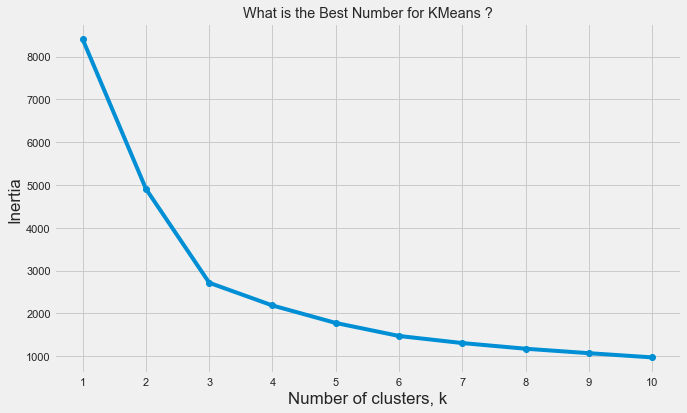

In [35]:
from sklearn.cluster import KMeans
ks = range(1,11)
inertias=[]
for k in ks :
    kc = KMeans(n_clusters=k,random_state=142)
    kc.fit(df_select_norm)
    cluster = kc.fit_predict(df_select_norm)
    inertias.append(kc.inertia_)
# Plot ks vs inertias
f, ax = plt.subplots(figsize=(10, 6))
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.style.use('ggplot')
plt.title('What is the Best Number for KMeans ?')
plt.show()

In [45]:
from sklearn.metrics import silhouette_score

range_n_clusters = list(range(2,11))
arr_silhouette_score_euclidean = []
for i in range_n_clusters:
    kmeans = KMeans(n_clusters=i).fit(df_select_norm)
    preds = kmeans.predict(df_select_norm)
     
    score_euclidean = silhouette_score(df_select_norm, preds, metric='euclidean')
    arr_silhouette_score_euclidean.append(score_euclidean)

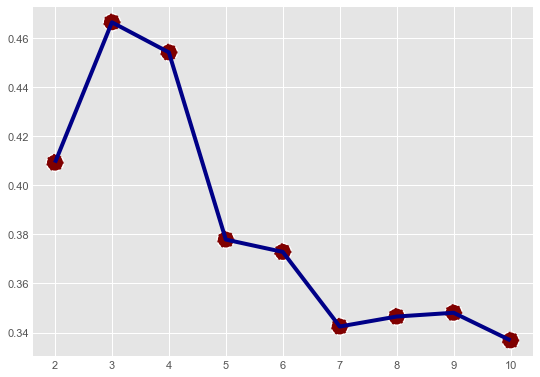

In [46]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(x=range(2,11), y=arr_silhouette_score_euclidean, color='#000087', linewidth = 4)
sns.scatterplot(x=range(2,11), y=arr_silhouette_score_euclidean, s=300, color='#800000',  linestyle='--')
plt.show()

Best Cluster = 3

K-Means Model

In [47]:

from sklearn.cluster import KMeans
kc = KMeans(init='k-means++',n_clusters= 3, random_state=142)
kc.fit(df_select_norm)
cluster_labels = kc.labels_

data_c = df_select_norm.assign(K_Cluster = cluster_labels)

data_f=data_c.groupby('K_Cluster').mean()
data_f['count']=pd.value_counts(data_c['K_Cluster'])
data_f

,MEMBERSHIP_DURATION_NORM,LAST_TO_END_NORM,FLIGHT_COUNT_NORM,SEG_KM_SUM_NORM,count
K_Cluster,,,,,
0,0.184949,0.126260,0.049554,0.030338,28405
1,0.692231,0.135417,0.067665,0.039334,18849
2,0.263937,0.650111,0.010314,0.010668,12033


In [53]:
data_c['clusters'] = kc.labels_

PCA Analysis

In [49]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

pca.fit(data_c)
pcs = pca.transform(data_c)

data_pca = pd.DataFrame(data = pcs, columns = ['PC 1', 'PC 2'])

data_pca.head()

,PC 1,PC 2
0,0.362591,0.580623
1,0.368782,0.497111
2,0.379502,0.241637
3,0.346911,0.278847
4,0.376613,0.333881


Wall time: 160 ms


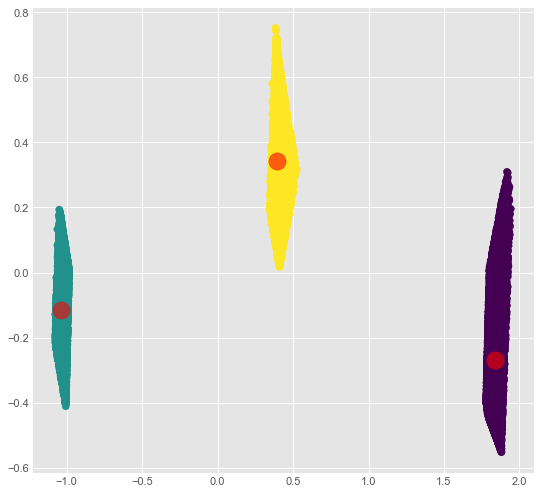

In [50]:
#kmeans
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
n_clusters = 3
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(data_c)
kmeans = KMeans(n_clusters= n_clusters, max_iter=600,random_state=142, algorithm = 'auto')

%time fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)
df_pred=data_c.assign(K_Cluster = prediction)
targets = [0, 1, 2, 3]
plt.figure(figsize = (8,8))
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1],c=prediction ,s=50, cmap='viridis')
centers2 = fitted.cluster_centers_
plt.scatter(centers2[:, 0], centers2[:, 1],c='red', s=300, alpha=0.6);

In [56]:
data_pca

,PC 1,PC 2
0,0.362591,0.580623
1,0.368782,0.497111
2,0.379502,0.241637
3,0.346911,0.278847
4,0.376613,0.333881
...,...,...
59282,1.790426,-0.425565
59283,0.385991,0.172337
59284,-1.038847,0.040213
59285,1.816035,-0.462820


In [57]:
clusters = kmeans.labels_
df['clusters'] = clusters

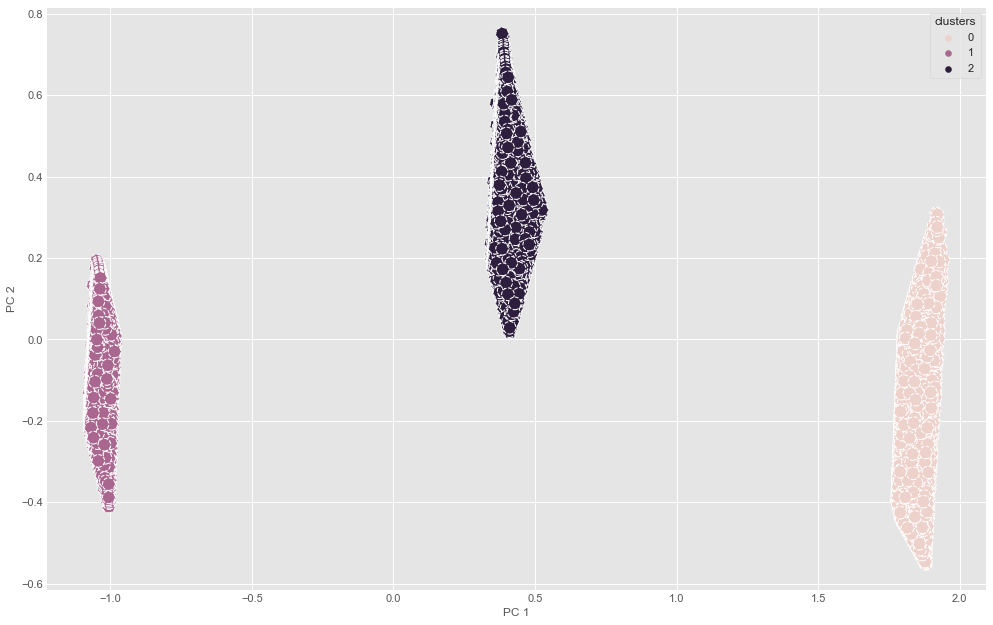

In [58]:
data_pca['clusters'] = clusters
fig, ax = plt.subplots(figsize=(15,10))

sns.scatterplot(
    x='PC 1', y='PC 2',
    hue='clusters',
    linestyle='--',
    data=data_pca,
    s=160,
    ax=ax
)

plt.show()

## Deskripsi setiap cluster

In [59]:
df[['MEMBERSHIP_DURATION', 'LAST_TO_END', 'FLIGHT_COUNT', 'SEG_KM_SUM', 'clusters']].groupby('clusters').median()

,MEMBERSHIP_DURATION,LAST_TO_END,FLIGHT_COUNT,SEG_KM_SUM
clusters,,,,
0,31.0,467.0,3.0,4575.0
1,28.0,71.0,8.0,11768.0
2,80.0,66.0,10.0,14608.0


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59287 entries, 0 to 62978
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   MEMBER_NO            59287 non-null  int64         
 1   FFP_DATE             59287 non-null  datetime64[ns]
 2   FIRST_FLIGHT_DATE    59287 non-null  datetime64[ns]
 3   GENDER               59287 non-null  object        
 4   FFP_TIER             59287 non-null  int64         
 5   WORK_CITY            59287 non-null  object        
 6   WORK_PROVINCE        59287 non-null  object        
 7   WORK_COUNTRY         59287 non-null  object        
 8   AGE                  59287 non-null  int32         
 9   LOAD_TIME            59287 non-null  datetime64[ns]
 10  FLIGHT_COUNT         59287 non-null  int64         
 11  BP_SUM               59287 non-null  int64         
 12  SUM_YR_1             59287 non-null  float64       
 13  SUM_YR_2             59287 non-

In [61]:
df.head()

,MEMBER_NO,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,FFP_TIER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,AGE,LOAD_TIME,...,LAST_FLIGHT_DATE,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight,MEMBERSHIP_DURATION,clusters
0,54993,2006-11-02,2008-12-24,Male,6,.,beijing,CN,31,2014-03-31,...,2014-03-31,1,3.483254,18,34,0.961639,619760,50,88,2
2,55106,2007-02-01,2007-08-30,Male,6,.,beijing,CN,40,2014-03-31,...,2014-03-21,11,5.298507,18,20,1.254676,406361,26,85,2
3,21189,2008-08-22,2008-08-23,Male,5,Los Angeles,CA,US,64,2014-03-31,...,2013-12-26,97,27.863636,73,11,1.090870,372204,12,67,2
4,39546,2009-04-10,2009-04-15,Male,6,guiyang,guizhou,CN,48,2014-03-31,...,2014-03-27,5,4.788079,47,27,0.970658,338813,39,59,2
5,56972,2008-02-10,2009-09-29,Male,6,guangzhou,guangdong,CN,64,2014-03-31,...,2014-01-13,79,7.043956,52,10,0.967692,343121,15,73,2


In [62]:
df['clusters'].value_counts().to_frame().reset_index().rename(columns={"index": "clusters", "clusters": "total_members"})

,clusters,total_members
0,1,28405
1,2,18849
2,0,12033


In [63]:
df[(df.clusters == 0)].describe()

,MEMBER_NO,FFP_TIER,AGE,FLIGHT_COUNT,BP_SUM,SUM_YR_1,SUM_YR_2,SEG_KM_SUM,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight,MEMBERSHIP_DURATION,clusters
count,12033.000000,12033.000000,12033.000000,12033.000000,12033.000000,12033.000000,12033.000000,12033.000000,12033.000000,12033.000000,12033.000000,12033.000000,12033.000000,12033.000000,12033.000000,12033.000000,12033.0
mean,31541.799717,4.007895,41.441370,4.176348,3887.633840,3594.656445,349.513338,6559.109366,475.581318,47.946797,85.856894,0.051774,0.716152,4450.560957,1.461730,37.657608,0.0
std,18157.695130,0.117547,10.332853,3.609281,5170.255404,4412.333543,1009.861605,6883.701127,119.354594,57.980048,84.933646,0.407985,0.204644,7491.592094,5.098014,20.999468,0.0
min,15.000000,4.000000,7.000000,2.000000,0.000000,0.000000,0.000000,368.000000,262.000000,0.000000,0.000000,0.000000,0.137586,0.000000,0.000000,11.000000,0.0
25%,15494.000000,4.000000,34.000000,2.000000,1447.000000,1408.000000,0.000000,2811.000000,373.000000,8.000000,10.000000,0.000000,0.579963,1540.000000,0.000000,21.000000,0.0
50%,31794.000000,4.000000,40.000000,3.000000,2492.000000,2440.000000,0.000000,4575.000000,467.000000,30.000000,64.000000,0.000000,0.714800,2746.000000,0.000000,31.000000,0.0
75%,47474.000000,4.000000,48.000000,5.000000,4627.000000,4319.000000,0.000000,7742.000000,569.000000,64.000000,135.000000,0.000000,0.833353,5144.000000,0.000000,50.000000,0.0
max,62977.000000,6.000000,91.000000,72.000000,195866.000000,181233.000000,27525.000000,219282.000000,731.000000,456.000000,457.000000,27.000000,1.500000,502044.000000,42.000000,112.000000,0.0


In [64]:
df[(df.clusters == 1)].describe()

,MEMBER_NO,FFP_TIER,AGE,FLIGHT_COUNT,BP_SUM,SUM_YR_1,SUM_YR_2,SEG_KM_SUM,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight,MEMBERSHIP_DURATION,clusters
count,28405.000000,28405.000000,28405.00000,28405.00000,28405.000000,28405.000000,28405.000000,28405.000000,28405.000000,28405.000000,28405.000000,28405.000000,28405.000000,28405.000000,28405.000000,28405.000000,28405.0
mean,32183.014117,4.098046,40.55367,12.45587,11196.278472,4883.134871,6369.542686,17974.598240,93.169442,77.874839,193.914698,0.210843,0.712338,12774.723147,2.886147,29.679845,1.0
std,18118.452866,0.362378,9.54242,12.78993,14916.106394,7345.147618,8154.695217,19761.209221,80.898115,85.103591,124.279610,0.805432,0.171310,18553.064449,7.360800,12.488046,0.0
min,6.000000,4.000000,6.00000,2.00000,0.000000,0.000000,0.000000,368.000000,1.000000,0.000000,0.000000,0.000000,0.112043,0.000000,0.000000,11.000000,1.0
25%,16242.000000,4.000000,33.00000,4.00000,3165.000000,690.000000,1779.000000,5945.000000,22.000000,29.458333,106.000000,0.000000,0.612417,3579.000000,0.000000,19.000000,1.0
50%,32562.000000,4.000000,39.00000,8.00000,6709.000000,2533.000000,3773.000000,11768.000000,71.000000,51.153846,167.000000,0.000000,0.705856,7506.000000,0.000000,28.000000,1.0
75%,49082.000000,4.000000,47.00000,16.00000,13630.000000,6240.000000,7746.000000,22763.000000,151.000000,92.000000,259.000000,0.000000,0.796816,15023.000000,1.000000,39.000000,1.0
max,62446.000000,6.000000,89.00000,197.00000,301864.000000,188926.000000,174895.000000,375074.000000,305.000000,720.000000,720.000000,22.000000,1.487487,985572.000000,111.000000,55.000000,1.0


In [65]:
df[(df.clusters == 2)].describe()

,MEMBER_NO,FFP_TIER,AGE,FLIGHT_COUNT,BP_SUM,SUM_YR_1,SUM_YR_2,SEG_KM_SUM,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight,MEMBERSHIP_DURATION,clusters
count,18849.000000,18849.000000,18849.000000,18849.000000,18849.000000,18849.000000,18849.000000,18849.000000,18849.000000,18849.000000,18849.000000,18849.000000,18849.000000,18849.000000,18849.000000,18849.000000,18849.0
mean,30548.261871,4.172688,45.535466,16.277256,15406.448140,7233.978832,8000.312483,23195.722691,99.854687,66.127869,179.053531,0.673935,0.738498,17880.087803,3.492970,80.915327,2.0
std,18228.542706,0.476802,9.061783,17.889251,20933.785822,10357.707734,10649.012381,25829.769893,103.882958,74.259406,119.585746,1.686295,0.187738,26732.175002,8.661061,14.632660,0.0
min,2.000000,4.000000,13.000000,2.000000,0.000000,0.000000,0.000000,368.000000,1.000000,0.000000,0.000000,0.000000,0.136017,0.000000,0.000000,54.000000,2.0
25%,12743.000000,4.000000,39.000000,5.000000,3810.000000,1088.000000,1940.000000,6880.000000,17.000000,24.344828,95.000000,0.000000,0.628136,4071.000000,0.000000,69.000000,2.0
50%,29898.000000,4.000000,45.000000,10.000000,8691.000000,3950.000000,4420.000000,14608.000000,66.000000,43.700000,153.000000,0.000000,0.720391,9543.000000,0.000000,80.000000,2.0
75%,46357.000000,4.000000,51.000000,21.000000,18694.000000,9299.000000,9763.000000,29663.000000,151.000000,78.714286,237.000000,1.000000,0.815967,21053.000000,2.000000,93.000000,2.0
max,62988.000000,6.000000,92.000000,213.000000,505308.000000,239560.000000,234188.000000,580717.000000,590.000000,728.000000,728.000000,46.000000,1.500000,795398.000000,140.000000,112.000000,2.0


Berdasarkan hasil dari clustering, diketahui terdapat 3 kategori customer berdasarkan periode membership, jumlah penerbangan, jarak penerbangan terakhir ke pesanan penerbangan terakhir, dan total jarak dari penerbangan yang sudah dilakukan, yaitu:

*   Cluster 0: Low value customer
a. Jarak penerbangan terakhir ke pesanan penerbangan terakhir paling lama
b. Durasi membershp paling baru
c. Jumlah penerbangan sedikit
d. Total jarak yang ditempuh sedikit

*   Cluster 1: Middle value customer, cukup loyal.
a. Jarak penerbangan terakhir ke pesanan penerbangan terakhir menegah/sedang
b. Durasi membershp menengah
c. Jumlah penerbangan sedang
d. Total jarak yang ditempuh menegah/sedang

*   Cluster 2: High value customer, sangat loyal.
a. Jarak penerbangan terakhir ke pesanan penerbangan terakhir paling dekat
b. Durasi membershp paling lama
c. Jumlah penerbangan paling banyak
d. Total jarak yang ditempuh banyak

## Rekomendasi Bisinis

Berdasarkan cluster tersebut, pihak maskapai sebaiknya meningkatkan interaksi kepada customer cluster 0 dan 1 agar mereka lebih sering menggunakan maskapai tersebut, bisa dengan cara memberikan promo ataupun diskon lainnya. Sedangkan untuk customer pada cluster 2 sebaiknya diberikan fasilitas khusus seperti ealry boarding time, vip lounge, dan sebagainya agar customer tersebut tetap loyal kepada maskapai.